In [1]:
import itertools

import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx

import meshplot as mp
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from src import shapes

# Define The Figure and the Morse Function

In [2]:
def get_linear_morse(vector=None):
    if vector is None:
        vector = np.random.random(4)
    vector = np.array(vector)
    def f(points):
        return points @ vector
    return f

direction = np.random.random(3)
direction /= np.linalg.norm(direction)

In [3]:
f_dist = lambda p: np.linalg.norm(p, axis=-1, ord=2)
f_linear = lambda p: p[:, 1]
#f = lambda p: (np.random.random(3)*p).sum(axis=-1)*(np.random.random(3)*p).sum(axis=-1)

In [4]:
def cylindrical_twist(vertices, k=1.0, mode="x", scale=1.0):
    """
    Nonlinear cylindrical twist diffeomorphism on R^3.

    vertices: (n,3) array
    mode:
      - "z": angle depends on z  (theta = k * tanh(z/scale))
      - "r": angle depends on radius r (theta = k * tanh(r/scale))
    k: twist strength (radians, roughly bounded by +/-k for tanh)
    scale: controls how quickly tanh saturates
    """
    if mode == 'x':
        v = vertices[:, [1, 2, 0]]
        v = cylindrical_twist(v, k=k, mode="z", scale=scale)
        v = v[:, [2, 0, 1]]
        return v
        
        
    v = vertices.copy()
    x, y, z = v[:, 0], v[:, 1], v[:, 2]

    r = np.sqrt(x*x + y*y)

    if mode == "z":
        theta = k * np.tanh(z / scale)
    elif mode == "r":
        theta = k * np.tanh(r / scale)
    else:
        raise ValueError('mode must be "z" or "r"')

    c, s = np.cos(theta), np.sin(theta)

    v[:, 0] = c * x - s * y
    v[:, 1] = s * x + c * y
    
    return v

In [5]:
n, m = 13, 12
vertices, faces = shapes.get_halftori_bouquet(leaves=3, n=n, m=m, l0=0.9, glue=False)

vertices = cylindrical_twist(vertices, k=-0.3, scale=1.5, mode='x')

vertices, faces = shapes.split_large_edges(vertices, faces, max_length=1.0)


print(f'faces.shape = {faces.shape}')

face_mean_values = f_linear(vertices[faces]).mean(axis=1)

p = mp.plot(vertices, faces, face_mean_values, shading={"wireframe": True})

faces.shape = (1282, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.70…

In [6]:
import numpy as np
import igl
import scipy.sparse as sp
import scipy.sparse.linalg as sla

# V: (n,3) float64, F: (m,3) int32/int64
# Make sure dtypes are friendly

# Cotangent Laplacian (sparse n x n)
L = igl.cotmatrix(vertices, faces)

# Mass matrix (Voronoi is common; barycentric also exists)
M = igl.massmatrix(vertices, faces, igl.MASSMATRIX_TYPE_VORONOI)

# Solve for the first k eigenpairs (smallest eigenvalues)
k = 20

# We want smallest eigenvalues near 0; shift-invert around 0 is usually robust
evals, evecs = sla.eigsh(
    -L,                # make PSD
    k=k,
    M=M,
    sigma=0.0,         # shift-invert around 0
    which="LM"         # largest magnitude in shifted system == smallest original
)

# Sort (eigsh may not return sorted)
idx = np.argsort(evals)
evals = evals[idx]
evecs = evecs[:, idx]

# evecs[:,0] should be ~constant (lambda ~ 0) on a closed connected manifold
# Vertex-wise eigenfunctions are columns of evecs: shape (n, k)
phi = evecs

# Optional: M-orthonormalize (eigsh usually already does, but numerical drift happens)
# Normalize each eigenvector so phi^T M phi = 1
for i in range(phi.shape[1]):
    nrm2 = phi[:, i].T @ (M @ phi[:, i])
    phi[:, i] /= np.sqrt(nrm2)

print("eigenvalues:", evals[:10])
print("phi shape:", phi.shape)



eigenvalues: [-1.19319975e-16  1.20131251e-01  1.25096552e-01  1.37395386e-01
  4.22472883e-01  4.34044501e-01  4.97674062e-01  8.53069729e-01
  8.62349326e-01  9.07786933e-01]
phi shape: (639, 20)


In [7]:
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3, dtype=faces.dtype), faces]).ravel()

pl = pv.Plotter(shape=(2, 3), window_size=(1000, 800))

for i_ax, i_val in enumerate([0, 1, 2, -3, -2, -1]):
    i_row = i_ax % 3
    i_col = i_ax //3
    
    pl.subplot(i_col, i_row)

    pl.add_text(f'Eigen Value = {evals[i_val]:.4f}')

    mesh = pv.PolyData(vertices, faces_pv)
    scalars_title = "Eigen Function Value {evals[i_val]:.4f}"
    mesh.point_data[scalars_title] = phi[:, i_val]  # per-vertex scalars
    pl.add_mesh(mesh, scalars=scalars_title, cmap="jet", smooth_shading=False, show_edges=True)

pl.link_views()
pl.show()


Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8ebaee18b0_0&reconnect=auto" class="pyvi…

In [8]:
eigen_basis = np.zeros(evals.shape)
eigen_basis[evals.argmax()] = 1

f = lambda p: phi[np.linalg.norm(np.array(p)[..., None, :] - vertices, axis=-1).argmin(axis=1)]@eigen_basis

f(np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1]]))

array([ 0.03835433,  0.02220058,  0.01755216, -0.0064093 ])

In [9]:
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3, dtype=faces.dtype), faces]).ravel()

mesh = pv.PolyData(vertices, faces_pv)
mesh.point_data["values"] = f(vertices)  # per-vertex scalars

p = pv.Plotter(window_size=(600, 600))
p.add_mesh(
    mesh,
    scalars="values",
    cmap="viridis",
    smooth_shading=False,   # helps show linear interpolation nicely
    show_edges=True,      # set True if you want to see triangle edges
)
p.add_scalar_bar(title="values")
p.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8eb524dbe0_1&reconnect=auto" class="pyvi…

# Paths

In [10]:
from src.ms import MorseSmale

In [11]:
ms = MorseSmale(faces, f(vertices), vertices, forest_method='steepest')
#ms = MorseSmale(faces, f(vertices), vertices, forest_method='spaning')
ms = MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')

paths = list(ms.iterate_paths())

In [12]:
from src import vis
from src.vis import plot_paths, plot_segmentation_forests, plot_ms_comparition


In [13]:
pl = plot_paths(ms)
pl.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8eb4d6a270_2&reconnect=auto" class="pyvi…

In [14]:
pl = plot_segmentation_forests(ms, plot_complex=True,  point_size=16)
pl.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8eb4d6b260_3&reconnect=auto" class="pyvi…

In [15]:
forest_methods = ['steepest', 'spaning']
mss = [MorseSmale(faces, f(vertices), vertices, forest_method=forest_method) for forest_method in forest_methods]
[ms.define_critical_points() for ms in mss]

pl = plot_ms_comparition(mss, forest_methods)
pl.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8eb4d69a60_4&reconnect=auto" class="pyvi…

In [16]:
ms0 =  MorseSmale(faces, f(vertices), vertices, forest_method='steepest')
ms1 =  MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')

ms0.define_critical_points()
ms1.define_critical_points()

In [17]:
pl = plot_ms_comparition([ms0, ms1], plot_segmentation_forests=False)
pl.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8d843dd490_5&reconnect=auto" class="pyvi…

# Simplification

In [18]:
#ms =  MorseSmale(faces, f_linear(vertices), vertices, forest_method='steepest')
ms =  MorseSmale(faces, f(vertices), vertices, forest_method='steepest')

In [19]:
faces_components = ms.define_decomposition_by_paths()
pd.Series(faces_components).value_counts().sort_index()

0     67
1     84
2     68
3     39
4     77
5     62
6     70
7     28
8     40
9     19
10    36
11    17
12    28
13    73
14    66
15    80
16    28
17    28
18    32
19    42
20    16
21    28
22    92
23    11
24    77
25    74
Name: count, dtype: int64

In [20]:
new_mesh = vis.get_pv_mesh(ms.vertices, ms.faces)
new_mesh.cell_data['component'] = ms.define_decomposition_by_paths()


pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, scalars="component", cmap="rainbow", smooth_shading=False, show_edges=True, categories=True)
for path in ms.get_paths():
    pl.add_mesh(pv.lines_from_points(vertices[path]), color='white', line_width=4)

pl.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8eb4dd8f20_6&reconnect=auto" class="pyvi…

In [21]:
chain = ms.get_paths()[0]

new_mesh = vis.get_pv_mesh(ms.vertices, ms.faces)
new_mesh.cell_data['distance from chain'] = ms.get_face_distances_from_chain(chain)


pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, scalars="distance from chain", cmap="turbo", smooth_shading=False, show_edges=True, categories=True)
pl.add_mesh(pv.lines_from_points(vertices[chain]), color='orangered', line_width=4)

pl.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8e1c136de0_7&reconnect=auto" class="pyvi…

In [22]:
pl = pv.Plotter(window_size=(600, 600))
pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, categories=True)

max_dists = np.linspace(0, 0.6, 4)
#max_dists = [0.2]

for i, max_dist in enumerate(max_dists):
    if len(max_dists) == 1:
        color = plt.get_cmap('jet')(1)
    else:
        color = plt.get_cmap('jet')(i/(len(max_dists) - 1))

    for geopath in ms.iterate_geodesics_homotopic_to_paths(max_distance=max_dist):
        if len(geopath) > 0:
            pl.add_mesh(pv.lines_from_points(geopath), color=color, line_width=6)

pl.show()

/home/fzimin/Projects/Rotation 2 - Chris Wojtan'/quadrangulation/src/ms.py:287: UserWarning: Wow! Uncomputable geodesic, some faces are missed. Returning the original path
  warnings.warn('Wow! Uncomputable geodesic, some faces are missed. Returning the original path')


Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8e1c29a300_8&reconnect=auto" class="pyvi…

In [23]:
crytical_type_colors_dict = {'min': 'lime', 'max': 'red', 'saddle': 'yellow', 'regular': 'lightgrey'}

In [25]:
import time

In [26]:
max_distance = np.inf

timer = time.perf_counter()
geodesics_graph0 = ms.get_geodesics_graph(simplify=False, max_distance=max_distance)
print(f'Computed geodesics without simplification in {time.perf_counter() - timer:.4f} seconds.')

timer = time.perf_counter()
geodesics_graph1 = ms.get_geodesics_graph(simplify=True, max_distance=max_distance)
print(f'Computed geodesics with simplification in {time.perf_counter() - timer:.4f} seconds.')


Computed geodesics without simplification in 27.6904 seconds.
Computed geodesics with simplification in 25.2030 seconds.


In [29]:
print(f'Not simplifyed graph contains {geodesics_graph0.number_of_nodes()} nodes and {geodesics_graph0.number_of_edges()} edges.')
print(f'Simplifyed graph contains {geodesics_graph1.number_of_nodes()} nodes and {geodesics_graph1.number_of_edges()} edges.')

Not simplifyed graph contains 24 nodes and 52 edges.
Simplifyed graph contains 24 nodes and 52 edges.


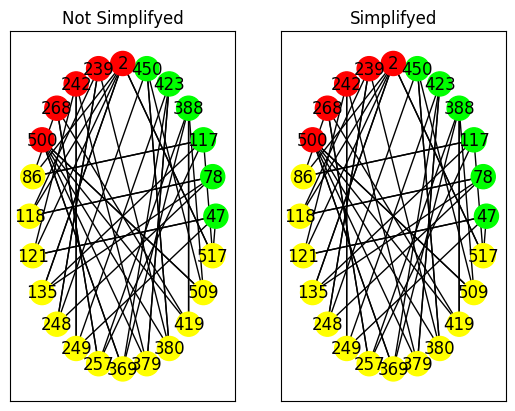

In [27]:
pos0 = nx.circular_layout(geodesics_graph0)
pos1 = nx.circular_layout(geodesics_graph1)
node_colors0 = pd.DataFrame([data for node, data in geodesics_graph0.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values
node_colors1 = pd.DataFrame([data for node, data in geodesics_graph1.nodes(data=True)]).fillna('regular')['critical_type'].map(crytical_type_colors_dict).apply(mcolors.to_hex).values

fig, axs = plt.subplots(1, 2)
axs[0].set_title('Not Simplifyed')
axs[1].set_title('Simplifyed')
nx.draw_networkx(geodesics_graph0, pos=pos0, node_color=node_colors0, ax=axs[0])
nx.draw_networkx(geodesics_graph1, pos=pos1, node_color=node_colors1, ax=axs[1])
plt.show()

In [30]:
pl = pv.Plotter(shape=(2, 2), window_size=(1000, 800))

for i_row, (title, graph) in enumerate(zip(['not simplifyed', 'simplifyed'], [geodesics_graph0, geodesics_graph1])):
    for i_col, path_attr in enumerate(['path', 'geopath']):
        pl.subplot(i_col, i_row)

        pl.add_text(f'{title} {path_attr}s')

        pl.add_mesh(new_mesh, color="white", smooth_shading=False, show_edges=True, opacity=0.4)

        for critical_type, color in crytical_type_colors_dict.items():
            pts = ms.vertices[[node for node, data in graph.nodes(data=True) if critical_type == data['critical_type']]]
            if len(pts) > 0:
                pl.add_mesh(pts, color=color, point_size=12, render_points_as_spheres=True)

        for e0, e1, data in graph.edges(data=True):
            pts = data[path_attr]
            if pts.ndim == 1:
                pts = ms.vertices[pts]
            pl.add_mesh(pv.lines_from_points(pts), color='midnightblue', line_width=4)

pl.link_views()
pl.show()

Widget(value='<iframe src="http://localhost:34711/index.html?ui=P_0x7b8d3437dd30_10&reconnect=auto" class="pyv…